In [1]:
__author__ = 'Robert Nikutta <nikutta@noao.edu>, NOAO Data Lab Team <datalab@noao.edu>'
__version__ = '20181227' # yyyymmdd
__datasets__ = ['smash_dr1'] # datasets used in this notebook
__keywords__ = ['lightcurve','time-series','Lomb-Scargle','period','vospace:copy']

# Time-series analysis of a RR Lyrae star
*Robert Nikutta & NOAO Data Lab Team*

### Table of contents
* [Imports & setup](#import)
* [Authentication](#login)
* [Query SMASH database for lightcurves](#querysmash)
* [Convert result to a convenient format](#convert)
* [Plot RA vs Dec](#scatterplot)
* [Plot time series](#plottimeseries)
* [Find period (Lomb-Scargle)](#lombscargle)
* [Fold and plot lightcurve](#fold)
* [Combine everything](#combine)
* [Store data to local file](#storelocal)
* [Copy data to your vospace](#copytovospace)
* [Further ideas](#ideas)
* [Resouces & references](#resources)

# Goals
* Query Data Lab for the time-series of a (known) variable star
* Make simple diagnostic plots of the data
* Find the variability period via Lomb-Scargle periodogram
* Phase the time-series and plot the lightcurve
* Combine the analysis steps into one routine
* Store resulting data into local file
* Copy data to the remote virtual storage space

# Summary
We will study the variability of an astrophysical object as a function of time. In the Hydra II dwarf galaxy, one object is a RR Lyrae star. We will get the lightcurve for it from the SMASH survey's `source` table, and build the analysis step by step.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass

# 3rd party
import numpy as np
import pylab as plt
from astropy import stats, units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import MaxNLocator
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

# plotting setup
fontsize = 14
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize

<a class="anchor" id="login"></a>
# Authentication
All Data Lab operations require a valid authentication token. Many operations however to not require a registered user account, and work just fine with an 'anonymous' token (the default). *This is one of the distinuguishing features of Data Lab: **open compute for everyone***.

However, if you wish to save your work and the datafiles permanently, beyond the duration of this session, the token for a registered user account is required. Further below this notebook will show you how you can save your work. To log in as a registered user, run this cell below:

In [3]:
token = ac.login(input("Enter user name (+ENTER): "),getpass("Enter password (+ENTER): "))

Enter user name (+ENTER): robertdemo
Enter password (+ENTER): ········


<a class="anchor" id="querysmash"></a>
# Retrieve multi-band lightcurves of the star from the SMASH survey
We retrieve all calibrated magnitudes of a specific object, for all bands, and all epochs, from the `source` table.

In [4]:
%%time

# Unique ID of a RR Lyrae star in Hydra II dwarf galaxy
objID = '169.429960'

# Select columns: RA, Dec, modified Julian date, calibrated mag, uncertainties, filter band
# Note: this database table encodes 'no measurement' values as 99.99
# Order the returned rows by ascending mod. Julian date
query = """SELECT ra,dec,mjd,cmag,cerr,filter
           FROM smash_dr1.source
           WHERE id='{:s}' AND cmag<99
           ORDER BY mjd ASC""".format(objID)
result = qc.query(query) # by default the result is a CSV formatted string

CPU times: user 28.5 ms, sys: 0 ns, total: 28.5 ms
Wall time: 103 ms


<a class="anchor" id="convert"></a>
# Convert result string to a convenient table format
The returned query result is a long string. Let's convert it to a more practical format, e.g. a Pandas dataframe. A Data Lab helper function accomplishes this very easily.

In [5]:
df = convert(result,'pandas')
print("Number of rows:", df.size)
print(df.head()) # print first few rows

Number of rows: 2286
           ra        dec           mjd     cmag      cerr filter
0  185.431155 -31.995327  56371.327538  21.4331  0.020651      g
1  185.431146 -31.995324  56371.328563  21.2316  0.022473      r
2  185.431139 -31.995320  56371.329582  21.1491  0.026192      i
3  185.431142 -31.995334  56371.330610  21.2379  0.045429      z
4  185.431145 -31.995325  56371.331633  21.3467  0.015112      g


The columns in the table can now be accessed by name, e.g.:

In [6]:
df['ra'][:3] # print first 3 elements in the RA column

0    185.431155
1    185.431146
2    185.431139
Name: ra, dtype: float64

<a class="anchor" id="scatterplot"></a>
# Plot RA vs Dec
We define a small plotting function. It can be re-used later.

In [7]:
def plot_scatter(x,y,ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    
    # apply units
    x = (x*u.deg).to('arcsec')
    y = (y*u.deg).to('arcsec')
    
    ax.plot(x-np.median(x),y-np.median(y),'bo',ms=3,alpha=0.6)
    ax.set_xlabel('RA offset ({:s})'.format(x.unit))
    ax.set_ylabel('DEC offset ({:s})'.format(y.unit))
    ax.axvline(0,c='0.5',lw=1)
    ax.axhline(0,c='0.5',lw=1)

Plot the RA and Dec coordinates of all observations for our source. They scatter around a median position:

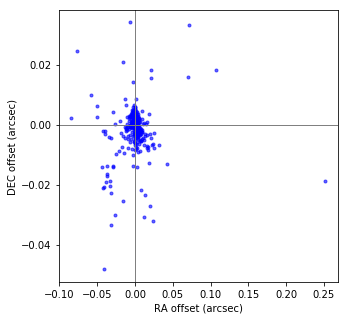

In [8]:
plot_scatter(df['ra'].values,df['dec'].values)

<a class="anchor" id="plottimeseries"></a>
# Plot times series
Plot the light-curves of this source for any selected band. We also zoom in on a range of dates with clustered measurements.

In [9]:
# define a function to select only measurements in one band
def get_data(df,band='g'):
    sel = (df['filter'] == band)    
    t = df['mjd'][sel].values
    y = df['cmag'][sel].values
    dy = df['cerr'][sel].values
    return t,y,dy # return time, magnitudes in one band, uncertainties

In [10]:
t,y,dy = get_data(df,'g')  # select one band

# a reusable function to plot the lightcurve
def plot_raw_lightcurve(t,y,dy,title='',ax=None,lperc=13,rperc=99):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
    
    jd0 = t.min() # modified Julian date offset
    t = t-jd0 # first date of observations = 0
    
    axins = inset_axes(ax, 3.5, 1.3, loc=9) # make inset axes object
    
    left = np.percentile(t,lperc)
    right = np.percentile(t,rperc)
    ax.errorbar(t,y,yerr=dy,marker='.',ms=8,ls='none',color='g',lw=1,alpha=0.5,label='')
    axins.errorbar(t,y,yerr=dy,marker='.',ms=8,ls='none',color='g',lw=1,alpha=0.5,label='')
    axins.set_xlim(0.9999*left,1.0001*right)
    axins.xaxis.set_major_locator(MaxNLocator(4))

    # Main panel chores
    ax.set_xlabel('modified Julian date - {:g} (days)'.format(jd0))
    ax.set_ylabel('magnitude')
    ax.invert_yaxis()
    ax.set_title(title)
    #ax.legend(loc='lower left',frameon=True,ncol=1,markerscale=1.5)

    # draw bbox around inset; connect with parent axes
    mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5",lw=1,alpha=0.7);

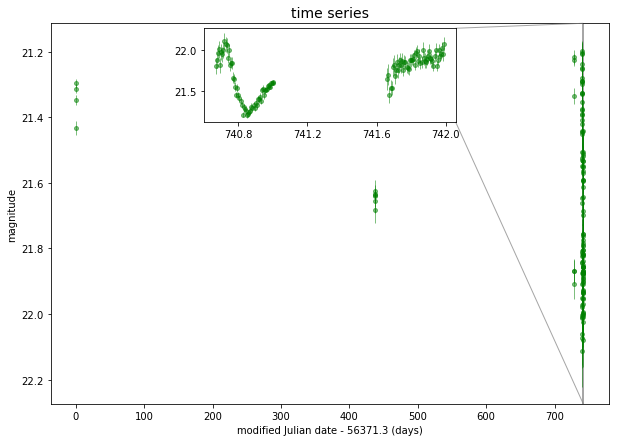

In [11]:
plot_raw_lightcurve(t,y,dy,title='time series',ax=None)

<a class="anchor" id="lombscargle"></a>
# Find periodicity
One of many methods for finding the period of a variable is the Lomb-Scargle periodogram. It works in the Fourier domain. We'll apply it here to all measurements of our RR Lyrae star in a given band.

In [12]:
def get_ls_periodogram(t,y,min_freq=1./1.,max_freq=1./0.1):
    
    """Compute Lomb-Scargle periodogram.
    
    Parameters
    ----------
    t : array
        Observation time array (e.g. MJD), ordered in ascending order.
    
    y : array
        Magnitude measurements at times ``t``.
        
    min_freq, max_freq : float or None
        The period finder can be guided by providing the min and max frequency
        in the ``y`` signal, in units 1/t. 
          min_freq = 1/longest expected period (in days)
          max_freq = 1/shortest expected perdiod (in days)
        The defaults are typical for RR Lyrae variability (RR Lyrae usually
        have a period of a fraction of one day).
        
    Returns
    -------
    period : array
        Phased period of the time-variable signal (fraction of the phase).
        
    power : array
        The periodogramm power as function if ``period``.
        
    """
    
    # Use astropy's LombScargle class
    ls = stats.LombScargle(t, y)

    # Compute the periodogram
    #   We guide the algorithm a bit:
    #     min_freq = 1/longest expected period (in days)
    #     max_freq = 1/shortest expected perdiod (in days)
    #   RR Lyrae usually have a period of a fraction of one day
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq)
    period = 1./frequency # period is the inverse of frequency
    
    return period, power


def get_best_period(period,power):
    
    """Return the period with highest power."""
    
    return period[np.argmax(power)]

In [13]:
# compute LS periodogram and from it, the best period
period, power = get_ls_periodogram(t,y)
best_period = get_best_period(period,power)

# Plot periodogram

In [14]:
def plot_periodogram(period,power,best_period=None,title='',ax=None):

    """Plot a periodogram.
    
    Parameters
    ----------
    
    period, power : array
        The period and power 1-d arrays as returned by :func:`get_ls_periodogram()`
    
    best_period : float or None
        If float, the value of this ``best_period`` will be marked in the plot.
    
    title : str
        Title of the figure. Default: ''.
    
    ax : instance or None
        If instance of axis class, will plot to that object. If None, will generate a new figure and axis object.
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
        
    ax.plot(period,power,lw=0.1)
    ax.set_xlabel('period (days)')
    ax.set_ylabel('relative power')
    ax.set_title(title)
    
    if best_period is not None:
        ax.axvline(best_period,color='r');
        ax.text(0.03,0.93,'period = {:.3f} days'.format(best_period),transform=ax.transAxes,color='r')

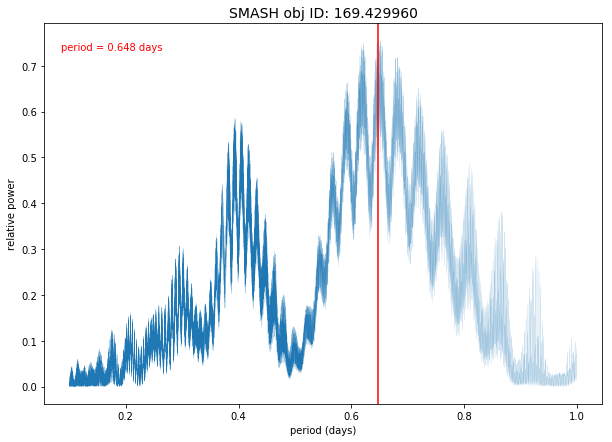

In [15]:
plot_periodogram(period,power,best_period,title='SMASH obj ID: 169.429960')

[Vivas et al. 2016](http://adsabs.harvard.edu/abs/2016AJ....151..118V) found with a (complementary!) phase dispersion minimization technique a period of 0.645 days. **We're in excellent agreement :-)**

<a class="anchor" id="fold"></a>
# Phase the entire lightcurve and plot it
With the true period computed, we can now "phase" (or "fold") the measured time series to produce a lightcurve as function of the period phase.

In [16]:
def get_folded_phase(t,best_period):
    
    """Fold the observation times with the best period of the variable signal."""
    
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (t / best_period) % 1
    
    return phase

In [17]:
def plot_folded_lightcurve(t,y,best_period,dy=None,ax=None):
    
    """Plot folded lightcurve.
    
    Parameters
    ----------
    
    t, y : array
        Time and magnitude 1-d arrays
        
    best_period : float
        True period of the signal.
        
    dy : array or None
        If array, the values are the uncertainies on ``y``, and the plot will show errorbars.
        If None, the plot will have no errorbars.
        
    ax : instance or None
        If instance of axis class, will plot to that object. If None, will generate a new figure and axis object.
    """

    phase = get_folded_phase(t,best_period)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,7))
        
    marker = '.'
    ms = 10
    lw = 1
    color = 'g'
    alpha = 0.6    
    
    if dy is not None:
        ax.errorbar(phase,y,yerr=dy,marker=marker,ms=ms,ls='none',lw=lw,color=color,alpha=alpha)
    else:
        ax.plot(phase,y,marker=marker,ms=ms,ls='none',lw=lw,color=color,alpha=alpha)
            
    ax.set_title('phased lightcurve')
    ax.invert_yaxis()
    ax.set_xlabel('phase (days)')
    ax.set_ylabel('magnitude');

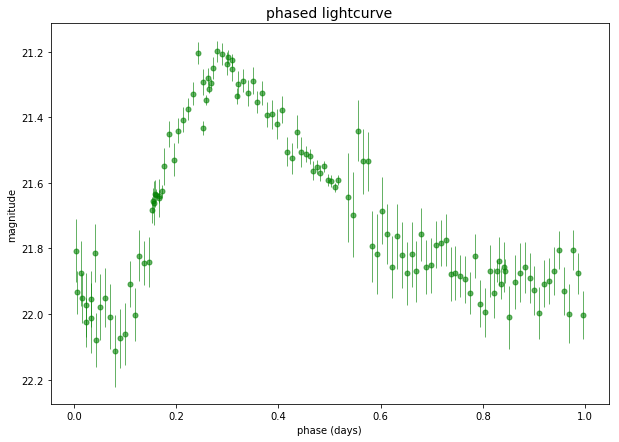

In [18]:
plot_folded_lightcurve(t,y,best_period,dy=dy)

<a class="anchor" id="combine"></a>
# Combine everything
With our modular functions, we can now combine everything into one neat analysis.

In [19]:
def do_everything(ra,dec,t,y,dy):
    # make fig & axes
    fig, axes = plt.subplots(2,2,figsize=(14,10))
    
    # plot data in sky
    plot_scatter(ra,dec,ax=axes[0,0])
    
    # plot lightcurve data
    plot_raw_lightcurve(t,y,dy,ax=axes[0,1])
    
    # plot periodogram
    period, power = get_ls_periodogram(t,y)
    best_period = get_best_period(period,power)
    plot_periodogram(period,power,best_period,ax=axes[1,0])
    
    # plot folded lightcurve
    plot_folded_lightcurve(t,y,best_period,dy=dy,ax=axes[1,1])
    
    fig.subplots_adjust(hspace=0.35,wspace=0.35)

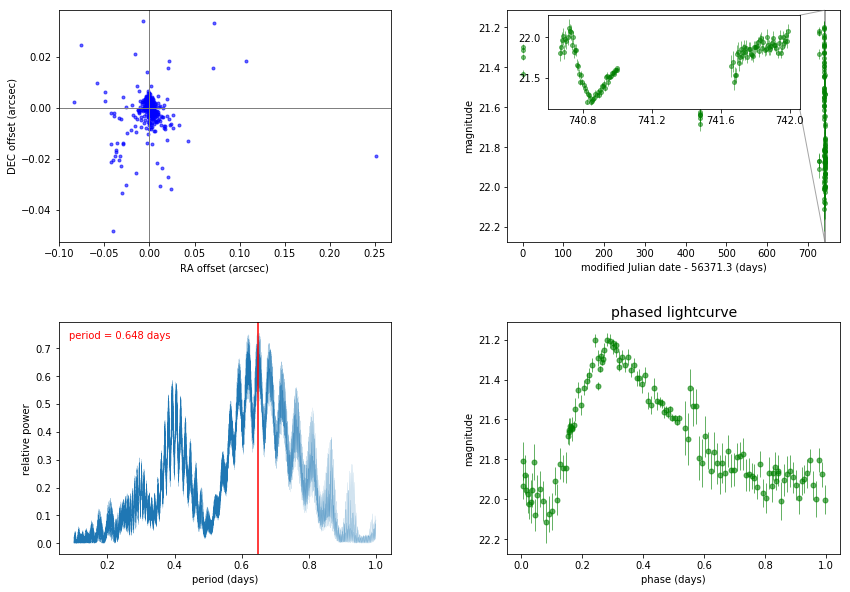

In [20]:
do_everything(df['ra'].values,df['dec'].values,t,y,dy)

# Package your analysis code in a simple Python source file, import, run here
All the functions we defined above can be placed in Python source code file, and thus easily transported to a different machine, run elsewhere, or imported and re-executed another time. Here, we placed all functions in the [`timeseries.py`](timeseries.py) file. To re-use the code, simply import it, and run the top-level function `do_everything` with your ra,dec,time and mag data. It should do the entire analysis in one go.

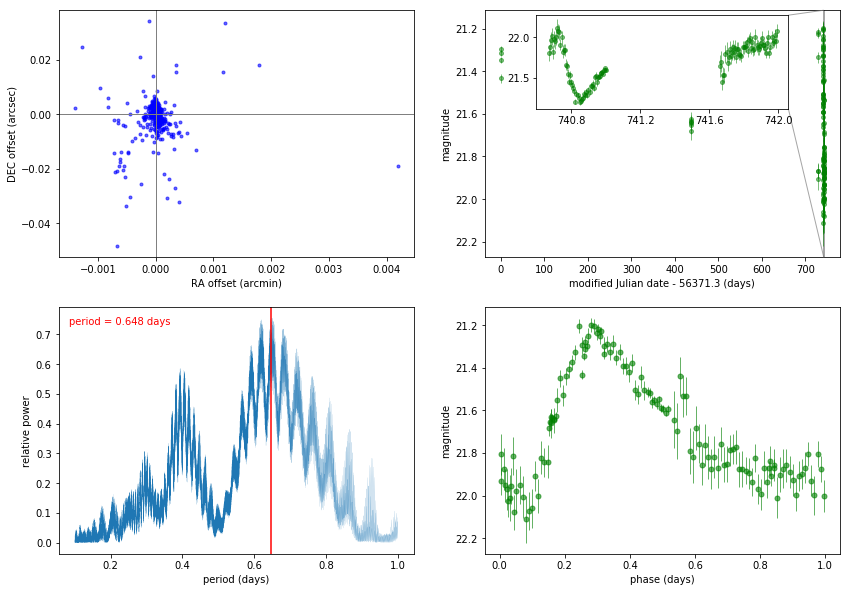

In [21]:
import timeseries
timeseries.do_everything(df['ra'].values,df['dec'].values,t,y,dy) # call with ra,dec,time,mag(=y),magerr(=dy)

<a class="anchor" id="storelocal"></a>
# Store the dataframe to a local file
You can easily export the data you've been working with to, for instance, a local CSV file:

In [22]:
df.to_csv('./timeseries.csv',index=False)

**Open or download the local file:** [timeseries.csv](timeseries.csv)

<a class="anchor" id="copytovospace"></a>
# Copy local file to your virtual storage space (vospace)
If you have logged in to Data Lab above, you have access to you own remote storage space called *vospace*. Let's copy the local file there, so that you can always access it later, even from a different computer!

In [23]:
print("Files in your vospace before copying: ", sc.ls(name='vos://'))
print("Copying file to vospace:               ",end="")
sc.put(fr='./timeseries.csv',to='vos://timeseries.csv') # this copies to local file to your remote vospace
print("After copying:                        ", sc.ls(name='vos://'))

Files in your vospace before copying:  newmags.csv,public,results,smashfoo1.csv,temp,tmp
Copying file to vospace:               (1 / 1) ./timeseries.csv -> vos://timeseries.csv
After copying:                         newmags.csv,public,results,smashfoo1.csv,temp,timeseries.csv,tmp


<a class="anchor" id="ideas"></a>
# Some further ideas

- Fit physical models of RR Lyrae pulsations

- template-based fitting

- run analysis on other variable stars

- identify other variables

<a class="anchor" id="resources"></a>
# Resources and references

Lomb, N.R. (1976) "Least-squares frequency analysis of unequally spaced data". Astrophysics and Space Science. 39 (2): 447–462: http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L

Scargle, J. D. (1982) "Studies in astronomical time series analysis. II - Statistical aspects of spectral analysis of unevenly spaced data". Astrophysical Journal. 263, 835: http://adsabs.harvard.edu/doi/10.1086/160554

Vivas et al. 2016 (2016, AJ, 151, 118) "Variable Stars in the Field of the Hydra II Ultra-Faint Dwarf Galaxy": http://adsabs.harvard.edu/abs/2016AJ....151..118V

Jake VanderPlas' blog on Lomb-Scargle periodograms and on fitting RR Lyrae lightcurves with templates: https://jakevdp.github.io/blog/2015/06/13/lomb-scargle-in-python/

Lomb-Scargle periodograms in `astropy`: http://docs.astropy.org/en/stable/stats/lombscargle.html

RR Lyrae variables on wikipedia: https://en.wikipedia.org/wiki/RR_Lyrae_variable